# Modeling a Pin-Cell
In this module, we'll demonstrate the basic features of the Python API for constructing input files and running OpenMC. In it, we will show how to create a basic reflective pin-cell model that is equivalent to modeling an infinite array of fuel pins. We highly recommend having a copy of the [Python API reference documentation](https://docs.openmc.org/en/stable/pythonapi/index.html) open in another browser tab that you can refer to.

For this example, we'll create a pin-cell of the CEFR fuel assembly with simplified material compositions. More accurate material compositions will be applied as part of the exercise at the end of the day.

- UO<sub>2</sub>
- Helium
- Sodium
- Stainless Steel

all at a temperature of 523.15 K.

The dimensions of our fuel pin will be as follows:
- Fuel pin center hole radius = 0.08020 cm
- Fuel outer radius = 0.0.25565 cm
- Clad inner radius = 0.27112 cm
- Clad outer radius = 0.30499 cm
- Fuel pin pitch = 0.695 cm

In [1]:
import openmc

In [2]:
# remote any existing OpenMC input XMl files and output HDF5 files
!rm *.xml *.h5

## Naming Conventions

Before we start working with the Python API, it's helpful to understand the naming convention of objects so that you can conceptualize what is a function, what is a class, etc. OpenMC's Python interface follows the same naming convention that is adopted by many/most Python projects:

- Module names are `lowercase`
- Functions are `lowercase_with_underscores`
- Classes are `CamelCase`
- Class attributes/variables are `lowercase_with_underscores`
- Top-level (global) variables are `UPPERCASE_WITH_UNDERSCORES`

To give a few specific examples:

- `openmc.deplete` is the depletion _module_
- `openmc.run` is a _function_
- `openmc.Material` is a _class_
- `openmc.data.ATOMIC_NUMBER` is a _top-level variable_

## Setting Attributes

When building OpenMC models, we will work with many different classes. Each class typically has _attributes_, a variable belonging to the class. When creating a class, you can often set those attributes directly when you instantiate the object, like this:

In [3]:
my_cell = openmc.Cell(name="box")

Or, you can assign values to attributes after you have already created the object. For example, the following is equivalent to the above:

In [4]:
my_other_cell = openmc.Cell()
my_other_cell.name = "box2"

You can in general also mix-and-match, setting some attributes when you instantiate the object, and others at a later point.

In [5]:
new_cell = openmc.Cell(name="box3")
new_cell.temperature = 500


## How to Get Help/Learn More

When building OpenMC models, we recommend having a copy of the Python API documentation (linked earlier) open. You can also query information about classes and methods directly from Jupyter. For example, we can use `help` to get documentation on all of the valid attributes for functions and classes.

In [6]:
help(openmc.Cell)

Help on class Cell in module openmc.cell:

class Cell(openmc.mixin.IDManagerMixin)
 |  Cell(cell_id=None, name='', fill=None, region=None)
 |  
 |  A region of space defined as the intersection of half-space created by
 |  quadric surfaces.
 |  
 |  Parameters
 |  ----------
 |  cell_id : int, optional
 |      Unique identifier for the cell. If not specified, an identifier will
 |      automatically be assigned.
 |  name : str, optional
 |      Name of the cell. If not specified, the name is the empty string.
 |  fill : openmc.Material or openmc.UniverseBase or openmc.Lattice or None or iterable of openmc.Material, optional
 |      Indicates what the region of space is filled with
 |  region : openmc.Region, optional
 |      Region of space that is assigned to the cell.
 |  
 |  Attributes
 |  ----------
 |  id : int
 |      Unique identifier for the cell
 |  name : str
 |      Name of the cell
 |  fill : openmc.Material or openmc.UniverseBase or openmc.Lattice or None or iterable of o

Attributes which have a default value will appear as `<attribute>=<the default value>` in the class/function definition. For classes, all of the member functions you can access will then be defined further down, with their associated documentation. To see documentation for just one specific function, you can use syntax like:

In [7]:
my_cell = openmc.Cell()
help(my_cell.from_xml_element)

Help on method from_xml_element in module openmc.cell:

from_xml_element(elem, surfaces, materials, get_universe) method of builtins.type instance
    Generate cell from XML element
    
    Parameters
    ----------
    elem : lxml.etree._Element
        `<cell>` element
    surfaces : dict
        Dictionary mapping surface IDs to :class:`openmc.Surface` instances
    materials : dict
        Dictionary mapping material ID strings to :class:`openmc.Material`
        instances (defined in :math:`openmc.Geometry.from_xml`)
    get_universe : function
        Function returning universe (defined in
        :meth:`openmc.Geometry.from_xml`)
    
    Returns
    -------
    openmc.Cell
        Cell instance



You can also query the type of a particular object using `type`. Note that we can also display the attributes for a particular object using `print`.

In [8]:
type(my_cell)
print(my_cell)

Cell
	ID             =	4
	Name           =	
	Fill           =	None
	Region         =	None
	Rotation       =	None
	Translation    =	None
	Volume         =	None



## Defining Materials

Materials in OpenMC are defined as a set of nuclides with specified atom/weight fractions. To begin, we will create a material by making an instance of the `Material` class. In OpenMC, many objects, including materials, are identified by a "unique ID" that is simply just a positive integer. These IDs are used when exporting XML files that the solver reads in. They also appear in the output and can be used for identification. Since an integer ID is not very useful by itself, you can also give a material a `name` as well.

In [9]:
uo2 = openmc.Material(1, "uo2")
print(uo2)                      

Material
	ID             =	1
	Name           =	uo2
	Temperature    =	None
	Density        =	None [sum]
	Volume         =	None [cm^3]
	S(a,b) Tables  
	Nuclides       



If you don't give an ID, one will be automatically generated for you:

In [10]:
mat = openmc.Material()
print(mat)

Material
	ID             =	2
	Name           =	
	Temperature    =	None
	Density        =	None [sum]
	Volume         =	None [cm^3]
	S(a,b) Tables  
	Nuclides       



We see that an ID of 2 was automatically assigned. Let's now move on to adding nuclides to our `uo2` material. The `Material` object has a method `add_nuclide()` whose first argument is the name of the nuclide and second argument is the atom or weight fraction.

In [11]:
help(uo2.add_nuclide)

Help on method add_nuclide in module openmc.material:

add_nuclide(nuclide: 'str', percent: 'float', percent_type: 'str' = 'ao') method of openmc.material.Material instance
    Add a nuclide to the material
    
    Parameters
    ----------
    nuclide : str
        Nuclide to add, e.g., 'Mo95'
    percent : float
        Atom or weight percent
    percent_type : {'ao', 'wo'}
        'ao' for atom percent and 'wo' for weight percent



We see that by default it assumes we want an atom fraction.

In [12]:
uo2.add_nuclide('U235', 1.49981E-02)
uo2.add_nuclide('U238', 8.26381E-03) 
uo2.add_nuclide('O16', 4.69512E-02)

Now we need to assign a total density to the material. We'll use the `set_density` for this.

In [13]:
uo2.set_density('atom/b-cm', density=7.02131E-02)

You may sometimes be given a material specification where all the nuclide densities are in units of atom/b-cm. In this case, you just want the density to be the sum of the constituents. In that case, you can simply run `mat.set_density('sum')`.

With UO2 finished, let's now create materials for the clad and coolant. Note the use of `add_element()` for zirconium.

In [14]:
steel = openmc.Material(name='SS')
steel.set_density('atom/b-cm', 0.49843E-02)
steel.add_element('Fe', 0.995)
steel.add_element('C', 0.005)

### Element Expansion

Did you notice something really cool that happened to our Fe and C elements? OpenMC automatically turned it into a list of nuclides when it exported it! The way this feature works is as follows:

- First, it checks whether `Materials.cross_sections` has been set, indicating the path to a `cross_sections.xml` file.
- If `Materials.cross_sections` isn't set, it looks for the `OPENMC_CROSS_SECTIONS` environment variable.
- If either of these is found, it scans the file to see what nuclides are actually available and will expand elements accordingly.

In [15]:
he4 = openmc.Material(name='he4')
he4.set_density('sum')
he4.add_element('He', 1.0E-11)

sodium = openmc.Material(name='Na')
sodium.set_density('sum')
sodium.add_nuclide('Na23', 2.33599E-02)

---
## An aside on S($\alpha$, $\beta$) tables

For systems with a significant thermal component to the neutron flux, it is important to augment the free atom cross sections we've used up to this point when possible. This can be done by using an $S(\alpha,\beta)$ table so that the bound atom cross section is used at thermal energies. To do this, there's an `add_s_alpha_beta()` method. Note the use of the GND-style name "c_H_in_H2O".

```python
water.add_s_alpha_beta('c_H_in_H2O')
```

---

When we go to run the transport solver in OpenMC, it is going to look for a `materials.xml` file. Thus far, we have only created objects in memory. To actually create a `materials.xml` file, we need to instantiate a `Materials` collection and export it to XML.

In [16]:
materials = openmc.Materials([uo2, steel, he4])

Note that `Materials` is actually a subclass of Python's built-in `list`, so we can use methods like `append()`, `insert()`, `pop()`, etc.

In [17]:
materials = openmc.Materials()
materials.append(sodium)
materials += [uo2, steel, he4]
isinstance(materials, list)

True

Finally, we can create the XML file with the `export_to_xml()` method. In a Jupyter notebook, we can run a shell command by putting `!` before it, so in this case we are going to display the `materials.xml` file that we created.

In [18]:
materials.export_to_xml()
!cat materials.xml

<?xml version='1.0' encoding='utf-8'?>
<materials>
  <material depletable="true" id="1" name="uo2">
    <density units="atom/b-cm" value="0.0702131"/>
    <nuclide ao="0.0149981" name="U235"/>
    <nuclide ao="0.00826381" name="U238"/>
    <nuclide ao="0.0469512" name="O16"/>
  </material>
  <material id="3" name="SS">
    <density units="atom/b-cm" value="0.0049843"/>
    <nuclide ao="0.05815775" name="Fe54"/>
    <nuclide ao="0.9129523" name="Fe56"/>
    <nuclide ao="0.02108405" name="Fe57"/>
    <nuclide ao="0.0028059" name="Fe58"/>
    <nuclide ao="0.005" name="C0"/>
  </material>
  <material id="4" name="he4">
    <density units="sum"/>
    <nuclide ao="1.9999999999999998e-17" name="He3"/>
    <nuclide ao="9.999979999999999e-12" name="He4"/>
  </material>
  <material id="5" name="Na">
    <density units="sum"/>
    <nuclide ao="0.0233599" name="Na23"/>
  </material>
</materials>


We see that now He3 and He4 were automatically added. Other isotopes are missing because our cross sections file (which is based on ENDF/B-VII.1) doesn't contain data for them. If OpenMC didn't know about the cross sections file, it would have assumed that all isotopes exist.

### Materials from a chemical formula

In [19]:
water = openmc.Material(name='water')
water.set_density('g/cc', 1.0)
water.add_elements_from_formula('H2O')
print(water)

Material
	ID             =	6
	Name           =	water
	Temperature    =	None
	Density        =	1.0 [g/cc]
	Volume         =	None [cm^3]
	S(a,b) Tables  
	Nuclides       
	H1             =	0.66656284   [ao]
	H2             =	0.00010382666666666666 [ao]
	O16            =	0.333207     [ao]
	O17            =	0.00012633333333333333 [ao]



### The `cross_sections.xml` file

The `cross_sections.xml` tells OpenMC where it can find nuclide cross sections and $S(\alpha,\beta)$ tables. It serves the same purpose as MCNP's `xsdir` file and Serpent's `xsdata` file. As we mentioned, this can be set either by the `OPENMC_CROSS_SECTIONS` environment variable or the `Materials.cross_sections` attribute.

Let's have a look at what's inside this file:

In [20]:
!cat $OPENMC_CROSS_SECTIONS | head -n 10
print('    ...')
!cat $OPENMC_CROSS_SECTIONS | tail -n 10

<?xml version='1.0' encoding='utf-8'?>
<cross_sections>
  <library materials="H1" path="H1.h5" type="neutron" />
  <library materials="H2" path="H2.h5" type="neutron" />
  <library materials="H3" path="H3.h5" type="neutron" />
  <library materials="He3" path="He3.h5" type="neutron" />
  <library materials="He4" path="He4.h5" type="neutron" />
  <library materials="Li6" path="Li6.h5" type="neutron" />
  <library materials="Li7" path="Li7.h5" type="neutron" />
  <library materials="Be7" path="Be7.h5" type="neutron" />
    ...
  <library materials="Cf253" path="wmp/098253.h5" type="wmp" />
  <library materials="Cf254" path="wmp/098254.h5" type="wmp" />
  <library materials="Es251" path="wmp/099251.h5" type="wmp" />
  <library materials="Es252" path="wmp/099252.h5" type="wmp" />
  <library materials="Es253" path="wmp/099253.h5" type="wmp" />
  <library materials="Es254" path="wmp/099254.h5" type="wmp" />
  <library materials="Es254_m1" path="wmp/099254m1.h5" type="wmp" />
  <library materi

The cross section dataset used by OpenMC can also be configured using the `openmc.config` property of the `openmc` module. Setting this property inside a Python interpreter session is equivalent to updating the cross sections environment variable discussed above.

In [21]:
# openmc.config['cross_sections'] = /path/to/my/xs/data/cross_sections.xml

### Enrichment

Note that the `add_element()` method has a special argument `enrichment` that can be used for Uranium. For example, if we know that we want to create 3% enriched UO2, the following would work:

In [22]:
uo2_three = openmc.Material()
uo2_three.add_element('U', 1.0, enrichment=3.0)
uo2_three.add_element('O', 2.0)
uo2_three.set_density('g/cc', 10.0)
print(uo2_three)

Material
	ID             =	7
	Name           =	
	Temperature    =	None
	Density        =	10.0 [g/cc]
	Volume         =	None [cm^3]
	S(a,b) Tables  
	Nuclides       
	U234           =	0.0002714687807976247 [ao]
	U235           =	0.030371951808732825 [ao]
	U238           =	0.9692174612830511 [ao]
	U236           =	0.00013911812741848606 [ao]
	O16            =	1.999242     [ao]
	O17            =	0.000758     [ao]



---

## Defining Geometry

At this point, we have three materials defined, exported to XML, and ready to be used in our model. To finish our model, we need to define the geometric arrangement of materials. OpenMC represents physical volumes using constructive solid geometry (CSG), also known as combinatorial geometry. The object that allows us to assign a material to a region of space is called a `Cell` (same concept in MCNP, for those familiar). There are four major stages in building a cell:

### Surfaces
In order to define a region that we can assign to a cell, we must first define surfaces which bound the region. A *surface* is a locus of zeros of a function of Cartesian coordinates $x$, $y$, and $z$, e.g.

- A plane perpendicular to the x axis: $x - x_0 = 0$
- A cylinder parallel to the z axis: $(x - x_0)^2 + (y - y_0)^2 - R^2 = 0$
- A sphere: $(x - x_0)^2 + (y - y_0)^2 + (z - z_0)^2 - R^2 = 0$

Between those three classes of surfaces (planes, cylinders, spheres), one can construct a wide variety of models. It is also possible to define cones and general second-order surfaces.

### Half-Spaces
Note that defining a surface is not sufficient to specify a volume -- in order to define an actual volume, one must reference the half-space of a surface. A surface *half-space* is the region whose points satisfy a positive or negative inequality of the surface equation. For example, for a sphere of radius one centered at the origin, the surface equation is $f(x,y,z) = x^2 + y^2 + z^2 - 1 = 0$. Thus, we say that the negative half-space of the sphere, is defined as the collection of points satisfying $f(x,y,z) < 0$, which one can reason is the inside of the sphere. Conversely, the positive half-space of the sphere would correspond to all points outside of the sphere.

### Regions
A region is then a combination (or just one) half-space.

### Cells

A Cell ties a region together with a "fill" (see below). Cells can be grouped together into `Universes` to produce replicated geometry (discussed in more detail later).

### Fills
Finally, a cell is complete once we have defined what is _filling_ the cell, which may be one of:

- material
- nothing (`None`), or vacuum/void
- universe
- lattice

In [23]:
sphere = openmc.Sphere(r=1.0, boundary_type='transmission')

Note that by default the sphere is centered at the origin so we didn't have to supply `x0`, `y0`, or `z0` arguments. Strictly speaking, we could have omitted `r` as well since it defaults to one. To get the negative or positive half-space, we simply need to apply the `-` or `+` unary operators, respectively.

(NOTE: Those unary operators are defined by special methods: `__pos__` and `__neg__` in this case).

In [24]:
inside_sphere = -sphere
outside_sphere = +sphere
type(inside_sphere)

openmc.surface.Halfspace

Now let's see if `inside_sphere` actually contains points inside the sphere:

In [25]:
print((0,0,0) in inside_sphere, (0,0,2) in inside_sphere)
print((0,0,0) in outside_sphere, (0,0,2) in outside_sphere)

True False
False True


Everything works as expected! Now that we understand how to create half-spaces, we can create more complex volumes by combining half-spaces using Boolean operators: `&` (intersection), `|` (union), and `~` (complement):

- `&`: logical AND
- `|`: logical OR
- `~`: logical NOT

For example, let's say we want to define a region that is the top part of the sphere (all points inside the sphere that have $z > 0$.

In [26]:
z_plane = openmc.ZPlane(0)
northern_hemisphere = -sphere & +z_plane
type(northern_hemisphere)

openmc.region.Intersection

For many regions, OpenMC can automatically determine a bounding box. To get the bounding box, we use the `bounding_box` property of a region, which returns a tuple of the lower-left and upper-right Cartesian coordinates for the bounding box:

In [27]:
northern_hemisphere.bounding_box

BoundingBox(lower_left=(-1.0, -1.0, 0.0), upper_right=(1.0, 1.0, 1.0))

Now that we see how to create volumes, we can use them to create a cell.

The full [list of available surfaces](https://docs.openmc.org/en/stable/pythonapi/base.html#building-geometry) is as follows.

Planes:

- `openmc.Plane` — An arbitrary plane of the form $Ax + By + Cz = D$
- `openmc.XPlane` — A plane perpendicular to the x axis of the form $x - x_0 = 0$
- `openmc.YPlane` — A plane perpendicular to the y axis of the form $y - y_0 = 0$
- `openmc.ZPlane` — A plane perpendicular to the z axis of the form $z - z_0 = 0$

Quadrics:

- `openmc.XCylinder` — An infinite cylinder whose length is parallel to the x-axis of the form $(y - y_0)^2 + (z - z_0)^2 = r^2$
- `openmc.YCylinder` — An infinite cylinder whose length is parallel to the x-axis of the form $(x - x_0)^2 + (z - z_0)^2 = r^2$
- `openmc.ZCylinder` — An infinite cylinder whose length is parallel to the x-axis of the form $(x - x_0)^2 + (y - y_0)^2 = r^2$
- `openmc.Sphere` — A sphere of the form $(x - x_0)^2 + (y - y_0)^2 + (z - z_0)^2 = r^2$
- `openmc.XCone` — A cone parallel to the x-axis of the form $(y - y_0)^2 + (z - z_0)^2 = r^2 (x - x_0)^2$
- `openmc.YCone` — A cone parallel to the y-axis of the form $(x - x_0)^2 + (z - z_0)^2 = r^2 (y - y_0)^2$
- `openmc.ZCone` — A cone parallel to the z-axis of the form $(x - x_0)^2 + (y - y_0)^2 = r^2 (z - z_0)^2$
- `openmc.Quadric` — A generic quadric surface

Torii:

- `openmc.XTorus` — A torus of the form $(x - x_0)^2/B^2 + (\sqrt{(y - y_0)^2 + (z - z_0)^2} - A)^2/C^2 - 1 = 0$
- `openmc.YTorus` — A torus of the form $(y - y_0)^2/B^2 + (\sqrt{(x - x_0)^2 + (z - z_0)^2} - A)^2/C^2 - 1 = 0$
- `openmc.ZTorus` — A torus of the form $(z - z_0)^2/B^2 + (\sqrt{(x - x_0)^2 + (y - y_0)^2} - A)^2/C^2 - 1 = 0$

### Boundary Conditions

When you create a surface, by default particles that pass through the surface will consider it to be transmissive, i.e. they pass through the surface freely. To specify boundary conditions, you simply need to set the `Surface.boundary_type` to one of:

- `vacuum`
- `reflective`
- `periodic` (either rotational or translational)
- `white`

In [28]:
sphere.boundary_type = 'vacuum'

In [29]:
cell = openmc.Cell()
cell.region = northern_hemisphere

# or...
cell = openmc.Cell(region=northern_hemisphere)

By default, the cell is not filled by any material (void). In order to assign a material, we set the `fill` property of a `Cell`.

In [30]:
cell.fill = steel

## Universes and in-line plotting

A collection of cells is known as a universe (again, this will be familiar to MCNP/Serpent users) and can be used as a repeatable unit when creating a model. Although we don't need it yet, the benefit of creating a universe is that we can visualize our geometry while we're creating it.

In [31]:
universe = openmc.Universe()
universe.add_cell(cell)

# this also works
universe = openmc.Universe(cells=[cell])

The `Universe` object has a `plot` method that will display our the universe as current constructed:

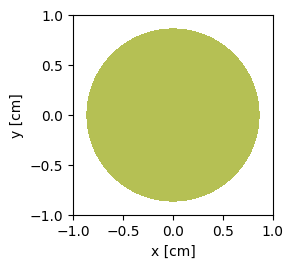

In [32]:
universe.plot(width=(2.0, 2.0))

By default, the plot will appear in the $x$-$y$ plane. We can change that with the `basis` argument.

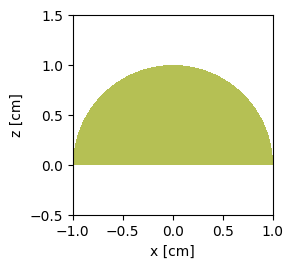

In [33]:
universe.plot(width=(2.0, 2.0), basis='xz')

If we have particular fondness for, say, fuchsia, we can tell the `plot()` method to make our cell that color.

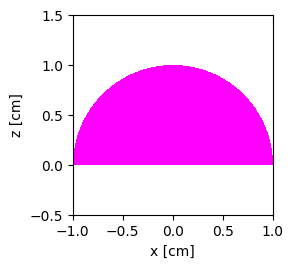

In [34]:
universe.plot(width=(2.0, 2.0), basis='xz',
              colors={cell: 'fuchsia'})

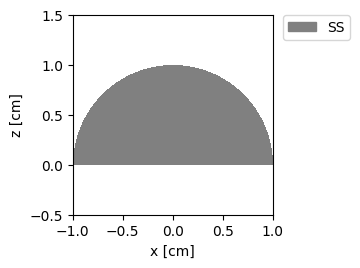

In [35]:
universe.plot(width=(2.0, 2.0), 
              basis='xz',
              color_by='material',
              colors={steel: 'grey'},
              legend=True)

---

## The CEFR pincell geometry

We now have enough knowledge to create our pin-cell. For CEFR, we need four surfaces to define the fuel and clad:

1. The inner surface of the fuel hole -- a cylinder parallel to the z axis
2. The outer surface of the fuel -- same as above
3. The inner surface of the cladding -- same as above
4. The outer surface of the cladding -- same as above

These four surfaces will all be instances of `openmc.ZCylinder`, each with a different radius according to the specification.

In [36]:
fuel_hole_radius = openmc.ZCylinder(r=0.08020)
fuel_outer_radius = openmc.ZCylinder(r=0.25565)
clad_inner_radius = openmc.ZCylinder(r=0.27112)
clad_outer_radius = openmc.ZCylinder(r=0.30499)

In [37]:
hole = -fuel_hole_radius
fuel_region = +fuel_hole_radius & -fuel_outer_radius
gap_region = +fuel_outer_radius & -clad_inner_radius
clad_region = +clad_inner_radius & -clad_outer_radius

In [38]:
fuel_hole = openmc.Cell(name='fuel hole')
fuel_hole.fill = he4
fuel_hole.region = hole

fuel = openmc.Cell(name='fuel')
fuel.fill = uo2
fuel.region = fuel_region

gap = openmc.Cell(name='he4 gap')
gap.fill = he4
gap.region = gap_region

clad = openmc.Cell(name='clad')
clad.fill = steel
clad.region = clad_region

Finally, we need to handle the coolant outside of our fuel pin. To do this, we create x- and y-planes that bound the geometry.

In [39]:
pitch = 0.695
left = openmc.XPlane(-pitch/2, boundary_type='reflective')
right = openmc.XPlane(pitch/2, boundary_type='reflective')
bottom = openmc.YPlane(-pitch/2, boundary_type='reflective')
top = openmc.YPlane(pitch/2, boundary_type='reflective')

The sodium region is going to be everything outside of the clad outer radius and within the box formed as the intersection of four half-spaces.

In [40]:
sodium_region = +left & -right & +bottom & -top & +clad_outer_radius

coolant = openmc.Cell(name='coolant')
coolant.fill = sodium
coolant.region = sodium_region

The final step is to assign the cells we created to a universe and tell OpenMC that this universe is the "root" universe in our geometry. The `Geometry` is the final object that is actually exported to XML.

In [41]:
root_universe = openmc.Universe(cells=(fuel_hole, fuel, gap, clad, coolant))

geometry = openmc.Geometry(root_universe)
geometry.export_to_xml()
!cat geometry.xml

<?xml version='1.0' encoding='UTF-8'?>
<geometry>
  <cell id="7" material="4" name="fuel hole" region="-3" universe="3"/>
  <cell id="8" material="1" name="fuel" region="3 -4" universe="3"/>
  <cell id="9" material="4" name="he4 gap" region="4 -5" universe="3"/>
  <cell id="10" material="3" name="clad" region="5 -6" universe="3"/>
  <cell id="11" material="5" name="coolant" region="7 -8 9 -10 6" universe="3"/>
  <surface coeffs="0.0 0.0 0.0802" id="3" type="z-cylinder"/>
  <surface coeffs="0.0 0.0 0.25565" id="4" type="z-cylinder"/>
  <surface coeffs="0.0 0.0 0.27112" id="5" type="z-cylinder"/>
  <surface coeffs="0.0 0.0 0.30499" id="6" type="z-cylinder"/>
  <surface boundary="reflective" coeffs="-0.3475" id="7" type="x-plane"/>
  <surface boundary="reflective" coeffs="0.3475" id="8" type="x-plane"/>
  <surface boundary="reflective" coeffs="-0.3475" id="9" type="y-plane"/>
  <surface boundary="reflective" coeffs="0.3475" id="10" type="y-plane"/>
</geometry>


# Starting source and settings

The Python API has a module `openmc.stats` with various univariate and multivariate probability distributions. We can use these distributions to create a starting source using the `openmc.Source` object. One can independently specify the spatial distribution (`space`), the angular distribution (`angle`), the energy distribution (`energy`), and the time distribution (`time`). For this example, we'll only specify the spatial distribution as a single point.

In [42]:
# Create a point source
point = openmc.stats.Point((0, 0.1, 0))
source = openmc.Source(space=point)

/home/ubuntu/openmc/openmc/source.py:388: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


Now let's create a `Settings` object and give it the source we created along with specifying how many batches and particles we want to run.

In [43]:
settings = openmc.Settings()
settings.source = source
settings.batches = 50
settings.inactive = 5
settings.particles = 1000

# ensure we're using unresolved probability tables for our fast reactor
settings.ptables = True

In [44]:
settings.export_to_xml()
!cat settings.xml

<?xml version='1.0' encoding='UTF-8'?>
<settings>
  <run_mode>eigenvalue</run_mode>
  <particles>1000</particles>
  <batches>50</batches>
  <inactive>5</inactive>
  <source particle="neutron" strength="1.0" type="independent">
    <space type="point">
      <parameters>0 0.1 0</parameters>
    </space>
  </source>
  <ptables>true</ptables>
</settings>


---

## Temperature Treatment

Generally, cross section data in OpenMC is specified at specific temperature values. Material or cell temperatures between these values can be used, however. OpenMC can model the temperature using a few different techniques:

  - **nearest**: OpenMC will use the nearest temperature cross section data available within some tolerance
  - **interpolate**: OpenMC will interpolate between the two nearest temperatures

[temperature treatment documentation](https://ec2-44-193-2-67.compute-1.amazonaws.com/)

For the CEFR model, we'll treat all of our materials as if they were at 523.15 K.

In [45]:
for m in materials:
    m.temperature = 523.15 # K

settings.temperature['method'] = 'nearest'
settings.temperature['tolerance'] = 100 # K

---

# Running OpenMC

Running OpenMC from Python can be done using the `openmc.run()` function. This function allows you to set the number of MPI processes and OpenMP threads, if need be.

In [46]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

Great! OpenMC already told us our k-effective.

# Geometry plotting

We saw before that we could call the `Universe.plot()` method to show a universe while we were creating our geometry. There is also a built-in plotter in the codebase that is much faster than the Python plotter and has more options. The interface looks somewhat similar to the `Universe.plot()` method. Instead though, we create `Plot` instances, assign them to a `Plots` collection, export it to XML, and then run OpenMC in geometry plotting mode. As an example, let's specify that we want the plot to be colored by material (rather than by cell) and we assign yellow to fuel and blue to water.

In [47]:
plot = openmc.Plot()
plot.filename = 'pinplot'
plot.width = (pitch, pitch)
plot.pixels = (200, 200)
plot.color_by = 'material'
plot.colors = {uo2: 'yellow', sodium: 'blue'}

With our plot created, we need to add it to a `Plots` collection which can be exported to XML.

In [48]:
plots = openmc.Plots([plot])
plots.export_to_xml()
!cat plots.xml

<?xml version='1.0' encoding='UTF-8'?>
<plots>
  <plot basis="xy" color_by="material" filename="pinplot" id="5" type="slice">
    <pixels>200 200</pixels>
    <origin>0.0 0.0 0.0</origin>
    <width>0.695 0.695</width>
    <color id="1" rgb="255 255 0"/>
    <color id="5" rgb="0 0 255"/>
  </plot>
</plots>


In [49]:
openmc.plot_geometry()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

Now, we can use functionality from IPython to display the `.png` image inline in our notebook:

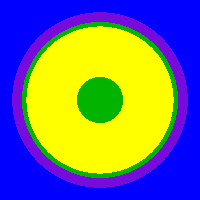

In [50]:
from IPython.display import Image
Image("pinplot.png")

OpenMC also provides us with a method on the `Plot` class that simplifies the workflow.

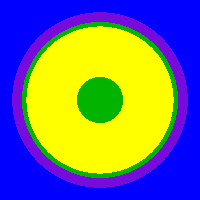

In [51]:
plot.to_ipython_image()

# The `Model` class

So far, we've seen that to create and simulate a model, we had to create an instance of `Geometry`, `Materials`, and `Settings` and call the `export_to_xml` method on each of them. OpenMC also provides a `Model` class that aggregates these classes together an provides a single `export_to_xml` method that will export all files.

In [52]:
# Combine the three classes into a single model
model = openmc.Model()
model.geometry = geometry
model.materials = materials
model.settings = settings

# Export all at once
model.export_to_xml()

The `Model` class also has `run` method that will both export single XML file (`model.xml`) *and* run a simulation, returning the name of the last statepoint file that was written:

<div class="alert alert-block alert-info">
Note: If both separate XML inputs (`materials.xml`, `geometry.xml`, `settings.xml`, ...) and a `model.xml` file are both present in OpenMC's run directory, the `model.xml` fill will be used instead of the separate XML inputs.    
</div>

In [53]:
model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

PosixPath('/home/ubuntu/ictp-workshop23-openmc/notebooks/openmc_tutorial/statepoint.50.h5')

As we'll see later, the `Model` class has other useful features and can be very useful for postprocessing work.

---

# Basic Tallies in OpenMC

**Learning Objectives:**

  - Understand application of filters and scores to create tallies
  - Apply tallies to an OpenMC simulation
  - Extract information from OpenMC statepoint files
  - Understand tally units and normalization
  - Plot tally results

In this section, we'll be looking at how to extract custom information from an OpenMC simulation in what is known as a tally. A tally accumulates statistical information during the simulation about particles when they eneter regions of phase space specified on the tally. The limits of these regions are set by filters applied to the tally. Scores and nuclides can also be applied to tallies to indicate what type of information is kept about the particle (e.g. reaction types, flux, heat, etc.).

Any tally in OpenMC can be described with the following form:

$$ 
 X = \underbrace{\int d\mathbf{r} \int d\mathbf{\Omega} \int
    dE}_{\text{filters}} \underbrace{f(\mathbf{r}, \mathbf{\Omega},
    E)}_{\text{scores}} \psi (\mathbf{r}, \mathbf{\Omega}, E)
$$

where filters set the limits of the integrals and the scoring function is convolved with particle information (e.g. reaction type, current material, etc.).

First, we'll import a few additional packages to help manage data and visualize results.

In [54]:
import numpy as np
from matplotlib import pyplot as plt

We'll continue to work with the CEFR pincell model we've developed thus far. Let's explore that model further.

In [55]:
model.geometry.root_universe

Universe
	ID             =	3
	Name           =	
	Geom           =	CSG
	Cells          =	[7, 8, 9, 10, 11]

In [56]:
model.geometry.get_all_materials()

OrderedDict([(4,
              Material
              	ID             =	4
              	Name           =	he4
              	Temperature    =	523.15
              	Density        =	None [sum]
              	Volume         =	None [cm^3]
              	S(a,b) Tables  
              	Nuclides       
              	He3            =	1.9999999999999998e-17 [ao]
              	He4            =	9.999979999999999e-12 [ao]),
             (1,
              Material
              	ID             =	1
              	Name           =	uo2
              	Temperature    =	523.15
              	Density        =	0.0702131 [atom/b-cm]
              	Volume         =	None [cm^3]
              	S(a,b) Tables  
              	Nuclides       
              	U235           =	0.0149981    [ao]
              	U238           =	0.00826381   [ao]
              	O16            =	0.0469512    [ao]),
             (3,
              Material
              	ID             =	3
              	Name           =	SS
           

In [57]:
model.tallies

[]

In this exercise we'll be adding tallies to perform a few different tasks:


  **1. Determine the energy and heat produced per fission** \
  **2. Plot the flux spectrum of the pincell** \
  **3. Plot reaction types based on material**
  
To do this we'll use a variety of different filters applied to different tallies. 

First, to determine the recoverable energy produced per fission we'll create a tally without filters to gather information on the fission reaction rate ("`fission`") and recoverable fission energy ("`kappa-fission`"). Because we want this information talllied throughout the model, a "global" tally, no filters need to be applied.



<div class="alert alert-block alert-info">
A full list of scores and their meanings can be found <a href=https://docs.openmc.org/en/stable/usersguide/tallies.html#scores >here</a>.
</div>

## Task 1: Energy released per fission

## [Link to tally score descriptions](https://docs.openmc.org/en/stable/usersguide/tallies.html#scores)

In [58]:
fission_tally = openmc.Tally()
fission_tally.scores = ['fission', 'kappa-fission']
print(fission_tally)

Tally
	ID             =	1
	Name           =	
	Filters        =	
	Nuclides       =	
	Scores         =	['fission', 'kappa-fission']
	Estimator      =	None
	Multiply dens. =	True


Similar to the `openmc.Materials` object, the `openmc.Tallies` object is a sub-class of Python's built-in `list` and is used to collect tallies for appliction to the model.

In [59]:
model.tallies = openmc.Tallies([fission_tally])

In [60]:
statepoint = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

If we list our current directory, we see that several new files have been created as a result of this run: `summary.h5`, `tallies.out`, and `statepoint.50.h5`. The summary file contains information about the simulation's setup (geometry, materials, meshes, etc.) in an HDF5 format. The `tallies.out` file contains a text output of all user-specified tallies for the simulation.

In [61]:
!cat tallies.out

 ============================>     TALLY 1     <============================

 Total Material
   Fission Rate                         0.800549 +/- 0.00352791
   Kappa-Fission Rate                   1.54954e+08 +/- 682552


This can be useful to quickly look at simple tally results, but isn't a great format to post-process simulation data. For that we'll look to the statepoint file.

In [62]:
!ls
print(f'Statepoint: {statepoint}')

cefr_hex_lattice.png  model.xml		     plots.xml	       summary.h5
geometry.xml	      openmc_tutorial.ipynb  settings.xml      tallies.out
materials.xml	      pinplot.png	     statepoint.50.h5
Statepoint: /home/ubuntu/ictp-workshop23-openmc/notebooks/openmc_tutorial/statepoint.50.h5


To extract information from the statepoint file we'll create an `openmc.StatePoint` object. The `statepoint.get_tally` function will search for tallies by scores, filters, nuclides, ids, and return the closest match. Exact matches can be speficied as well.

In [63]:
with openmc.StatePoint(statepoint) as sp:
    tally_by_scores = sp.get_tally(scores=['fission', 'kappa-fission'])
    tally_by_id = sp.get_tally(id=fission_tally.id)

If we print the tally objects returned, we see that they indeed match the tally specification we generated above.

In [64]:
print(tally_by_scores)
print(tally_by_id)
# shorten variable name f
tally = tally_by_id 

Tally
	ID             =	1
	Name           =	
	Filters        =	
	Nuclides       =	total
	Scores         =	['fission', 'kappa-fission']
	Estimator      =	tracklength
	Multiply dens. =	True
Tally
	ID             =	1
	Name           =	
	Filters        =	
	Nuclides       =	total
	Scores         =	['fission', 'kappa-fission']
	Estimator      =	tracklength
	Multiply dens. =	True


<div class="alert alert-block alert-info">
<b>A quick aside on how statepoint objects interact with summary files:</b>


The `openmc.statepoint` object will read information from the `summary.h5` file if one is present, keeping that file open in the Python interpreter. The open `summary.h5` file can interfere with the initialization of subsequent OpenMC simulations. It is recommended that information be extracted from statepoints within a [context manager](https://book.pythontips.com/en/latest/context_managers.html) as we do here. Alternatively, making sure to call the `openmc.StatePoint.close` method will work also. For more details please look to the [relevant section in the user's guide](https://docs.openmc.org/en/stable/usersguide/troubleshoot.html#runtimeerror-failed-to-open-hdf5-file-with-mode-w-summary-h5).   
</div>



To compute the energy released per fission event, we can simply take the tallied energy released per fission and divide it by the fission rate.

In [65]:
f = tally.get_values(scores=['fission', 'kappa-fission'])
print(f.shape)

(1, 1, 2)


In [66]:
openmc.Tally.get_values?

Signature:
openmc.Tally.get_values(
    self,
    scores=[],
    filters=[],
    filter_bins=[],
    nuclides=[],
    value='mean',
)
Docstring:
Returns one or more tallied values given a list of scores, filters,
filter bins and nuclides.

This method constructs a 3D NumPy array for the requested Tally data
indexed by filter bin, nuclide bin, and score index. The method will
order the data in the array as specified in the parameter lists.

Parameters
----------
scores : list of str
    A list of one or more score strings
    (e.g., ['absorption', 'nu-fission']; default is [])
filters : Iterable of openmc.FilterMeta
    An iterable of filter types
    (e.g., [MeshFilter, EnergyFilter]; default is [])
filter_bins : list of Iterables
    A list of tuples of filter bins corresponding to the filter_types
    parameter (e.g., [(1,), ((0., 0.625e-6),)]; default is []). Each
    tuple contains bins for the corresponding filter type in the filters
    parameter. Each bins is the integer ID for 

The array of results returned from the `Tally.get_values` method returns an array with 3 dimensions: one for filter bins, one for nuclides, and one for the scores requested.

In [67]:
help(openmc.Tally.get_values)

Help on function get_values in module openmc.tallies:

get_values(self, scores=[], filters=[], filter_bins=[], nuclides=[], value='mean')
    Returns one or more tallied values given a list of scores, filters,
    filter bins and nuclides.
    
    This method constructs a 3D NumPy array for the requested Tally data
    indexed by filter bin, nuclide bin, and score index. The method will
    order the data in the array as specified in the parameter lists.
    
    Parameters
    ----------
    scores : list of str
        A list of one or more score strings
        (e.g., ['absorption', 'nu-fission']; default is [])
    filters : Iterable of openmc.FilterMeta
        An iterable of filter types
        (e.g., [MeshFilter, EnergyFilter]; default is [])
    filter_bins : list of Iterables
        A list of tuples of filter bins corresponding to the filter_types
        parameter (e.g., [(1,), ((0., 0.625e-6),)]; default is []). Each
        tuple contains bins for the corresponding filte

In [68]:
fission_rate = tally.get_values(scores=['fission']).flatten()[0]
kappa_fission = tally.get_values(scores=['kappa-fission']).flatten()[0]
ev_per_fission = kappa_fission / fission_rate
mev_per_fission = ev_per_fission * 1e-6
print(f'MeV per fission: {mev_per_fission:.2f}')

MeV per fission: 193.56


For a water reactor with U235 as the only fissioning isotope this is about what we would expect: ~193-194 MeV! Okay, on to some new tallies with filters.

As with most values coming out of an MC code, the tally values in the statepoint file are per source-particle. In this case, these units cancel out, but this will not be the case in our next example.

---

## Task 2: Plot the neutron flux spectrum


To perform this task, we'll be applying a tally with an energy filter and a score. OpenMC's data module contains different group structures. For this problem we'll use the CASMO-70 group structure. An energy filter can easily be created from a pre-defined group structure in OpenMC as follows:

In [69]:
# note to self: add the ANL fast reactor group structures
openmc.mgxs.GROUP_STRUCTURES.keys()

dict_keys(['CASMO-2', 'CASMO-4', 'CASMO-8', 'CASMO-16', 'CASMO-25', 'CASMO-40', 'VITAMIN-J-42', 'SCALE-44', 'MPACT-51', 'MPACT-60', 'MPACT-69', 'CASMO-70', 'XMAS-172', 'VITAMIN-J-175', 'SCALE-252', 'TRIPOLI-315', 'SHEM-361', 'CCFE-709', 'UKAEA-1102', 'ECCO-1968'])

In [70]:
energy_filter = openmc.EnergyFilter.from_group_structure('CASMO-70')
len(energy_filter.bins)

70

In [71]:
spectrum_tally = openmc.Tally()
spectrum_tally.filters = [energy_filter]
spectrum_tally.scores = ['flux']
print(spectrum_tally)

Tally
	ID             =	2
	Name           =	
	Filters        =	EnergyFilter
	Nuclides       =	
	Scores         =	['flux']
	Estimator      =	None
	Multiply dens. =	True


Now we'll apply this tally and re-run the problem

In [72]:
model.tallies = [spectrum_tally]
statepoint = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [73]:
with openmc.StatePoint(statepoint) as sp:
    tally = sp.get_tally(id=spectrum_tally.id)
    sp.get_tally(scores=['flux'])
    sp.get_tally(filters=spectrum_tally.filters)

In [74]:
spectrum = tally.mean

Now to plot the spectrum

/home/ubuntu/openmc/openmc/filter.py:1388: RuntimeWarning: divide by zero encountered in divide
  return np.log10(self.bins[:, 1]/self.bins[:, 0])


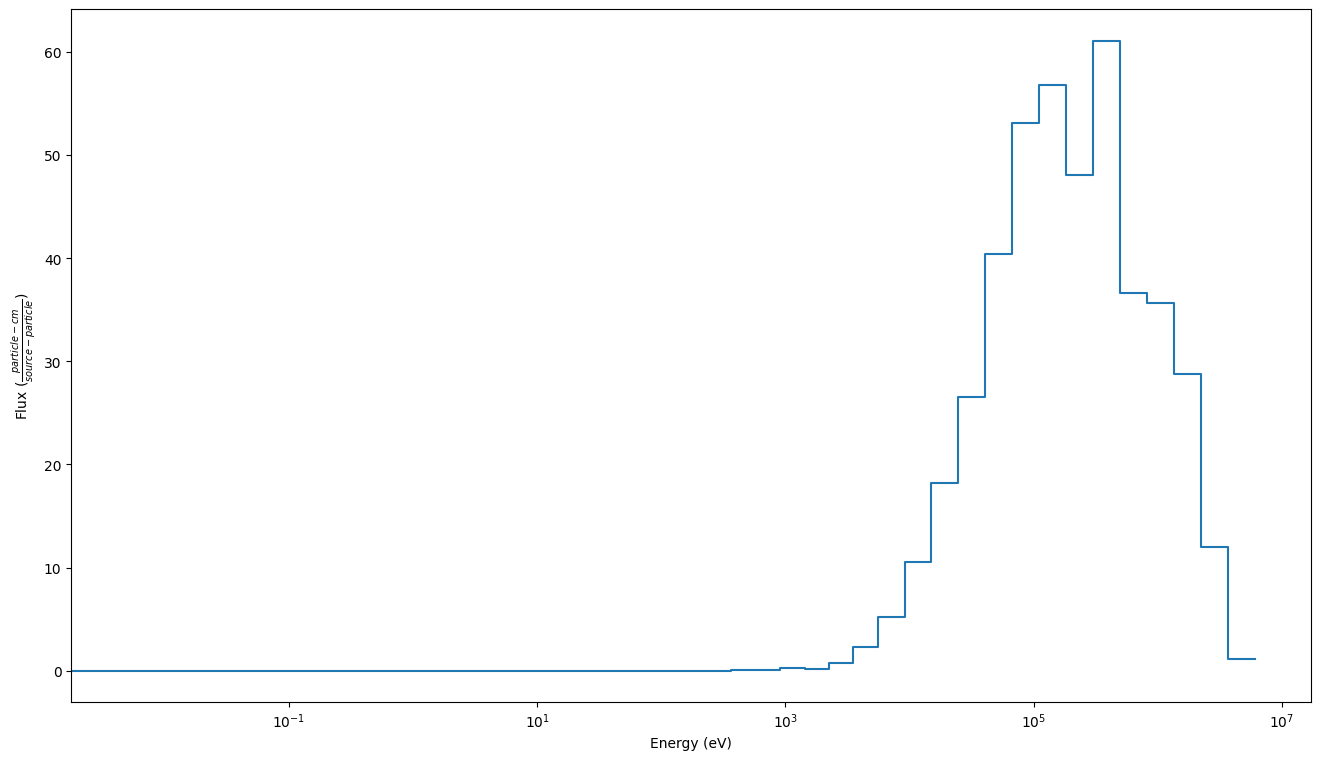

In [75]:
plt.figure(figsize=(16, 9))

bin_boundaries = energy_filter.lethargy_bin_width

plt.step(np.unique(energy_filter.bins)[:-1], spectrum.flatten() / bin_boundaries)
plt.xscale('log')
plt.rcParams['text.usetex'] = False
plt.xlabel(r'Energy (eV)')
plt.ylabel(r'Flux ($\frac{particle-cm}{source-particle}$)')
plt.show()

## Normalizing Tallies

Note that the units of flux in the above plot are in $\frac{particle-cm}{source-particle}$. As is the case with many values tallied by Monte Carlo codes, the value of the flux does not account for volume and is in terms of the number of source particles emitted. To generate this same plot in terms of absolute flux units ($\frac{particle}{cm^{2}-s}$) we'll need to normalize this tally by:

  - the volume of the region the tally covers
  - the number of source particle emitted

In this case, the volume of the region is the volume of the entire pincell. Because we're working with a 2-D model, we'll get units that give us the flux per unit length of the pincell in the axial direction. For simplicity, we'll assume that our pincell is 1 cm in height to make life easier. OpenMC's geometry object allows for computation of a bounding box for geometries like this that will help make this more straight forward.

In [76]:
# get bounding box
lower_left, upper_right = model.geometry.bounding_box
print(lower_left, upper_right)
lower_left[-1] = 0.0
upper_right[-1] = 1.0
# compute volume
volume = np.prod(upper_right - lower_left)
print(f'Model volume: {volume} cm^3')

[-0.3475 -0.3475    -inf] [0.3475 0.3475    inf]
Model volume: 0.4830249999999999 cm^3


Determining the number of source particles per second is more complicated, however. This means computing the eV/source particle due to fission. To get the source rate, we'll need the following pieces of information:

  1. the total power produced in the tally region (known a priori)
  2. the heat produced by fission power, per source particle
  
 To get this information we'll need to construct another tally to get additional information from the simulation.

In [77]:
pincell_power = 65E6 / 79 / 61 / 200 # [W/cm]
source_tally = openmc.Tally()
source_tally.scores = ['kappa-fission']
model.tallies = [source_tally]
model.export_to_xml()

In [78]:
sp_file = model.run(output=False)

In [79]:
with openmc.StatePoint(sp_file) as sp:
    source_tally_out = sp.get_tally(id=source_tally.id)
    heating = source_tally_out.get_values(scores=['kappa-fission']).flatten()[0]

The combination of the following tally values and power provide us with the source normalization needed as follows:


$$ \text{neutron source} [\frac{n}{s}] = \frac{1}{\text{heat per fission} [\frac{eV}{source}]} [\frac{source}{eV}]\times \frac{1}{1.6\times 10^{-19}} [\frac{eV}{J}] \times \text{power} [\frac{J}{s}]$$ 

In [80]:
J_to_eV = 1 / 1.6e-19
neutron_source = pincell_power * J_to_eV * (1 / heating)
print(f'Neutron source: {neutron_source:.2e} n/s')

Neutron source: 2.72e+12 n/s


We can now use this information to normalize our flux values and reproduce our plot in more standard units.

In [81]:
normalized_spectrum = neutron_source * spectrum.flatten() / volume

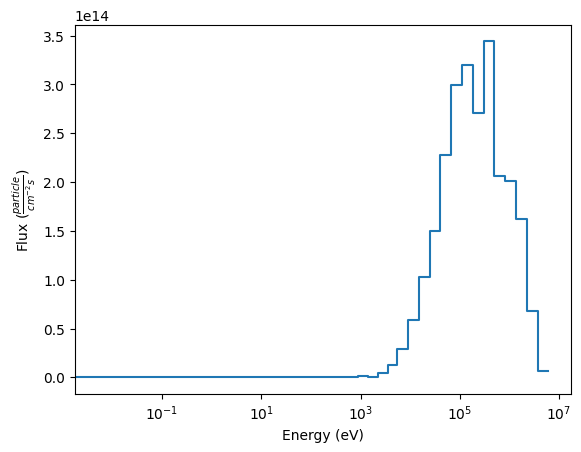

In [82]:
#plt.figure(figsize=(16, 9))
plt.step(np.unique(energy_filter.bins)[:-1], normalized_spectrum / bin_boundaries)
plt.xscale('log')
plt.rcParams['text.usetex'] = False
plt.xlabel(r'Energy (eV)')
plt.ylabel(r'Flux ($\frac{particle}{cm^{-2} s}$)')
plt.show()

---

## Task 3: Reaction Types by Material

Looking at the different reaction types by material will require a material filter and the set of reaction types we want to score. For this example, we'll be scoring absorption, scattering and fission in each material.

To start, we'll create a material filter.

In [83]:
model.materials

[Material
 	ID             =	5
 	Name           =	Na
 	Temperature    =	523.15
 	Density        =	None [sum]
 	Volume         =	None [cm^3]
 	S(a,b) Tables  
 	Nuclides       
 	Na23           =	0.0233599    [ao],
 Material
 	ID             =	1
 	Name           =	uo2
 	Temperature    =	523.15
 	Density        =	0.0702131 [atom/b-cm]
 	Volume         =	None [cm^3]
 	S(a,b) Tables  
 	Nuclides       
 	U235           =	0.0149981    [ao]
 	U238           =	0.00826381   [ao]
 	O16            =	0.0469512    [ao],
 Material
 	ID             =	3
 	Name           =	SS
 	Temperature    =	523.15
 	Density        =	0.0049843 [atom/b-cm]
 	Volume         =	None [cm^3]
 	S(a,b) Tables  
 	Nuclides       
 	Fe54           =	0.05815775   [ao]
 	Fe56           =	0.9129523    [ao]
 	Fe57           =	0.02108405   [ao]
 	Fe58           =	0.0028059    [ao]
 	C0             =	0.005        [ao],
 Material
 	ID             =	4
 	Name           =	he4
 	Temperature    =	523.15
 	Density        =	None [sum]
 	V

In [84]:
material_filter = openmc.MaterialFilter(model.materials)

In [85]:
material_tally = openmc.Tally()
material_tally.filters = [material_filter]
material_tally.scores = ['absorption', 'scatter', 'fission']

In [86]:
model.tallies = [material_tally]

In [87]:
statepoint = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

Now we'll gather information from the statepoint file about each score we applied to the tally. With multiple scores and materials, we'll use a Pandas data frame to view the results in a more coherent manner.

In [88]:
with openmc.StatePoint(statepoint) as sp:
    tally = list(sp.tallies.values())[0]
    absorption = tally.get_values(scores=['absorption']).flatten()
    scatter = tally.get_values(scores=['scatter']).flatten()
    fission = tally.get_values(scores=['fission']).flatten()
    df = tally.get_pandas_dataframe()

Each score has three values -- one for each material in the model.

In [89]:
df

,material,nuclide,score,mean,std. dev.
0,5,total,absorption,9.612445e-04,2.288010e-05
1,5,total,scatter,3.351673e+00,1.473991e-02
2,5,total,fission,0.000000e+00,0.000000e+00
3,1,total,absorption,1.004510e+00,4.692259e-03
4,1,total,scatter,1.330491e+01,6.068270e-02
5,1,total,fission,8.005493e-01,3.527908e-03
6,3,total,absorption,4.689115e-04,4.640526e-06
7,3,total,scatter,2.486366e-01,1.432234e-03
8,3,total,fission,0.000000e+00,0.000000e+00
9,4,total,absorption,2.774463e-16,1.645159e-18


First, we'll add a new column to the data frame with normalized results.

In [90]:
df['normalized-mean (rxn/s)'] = neutron_source * df['mean']
df

,material,nuclide,score,mean,std. dev.,normalized-mean (rxn/s)
0,5,total,absorption,9.612445e-04,2.288010e-05,2.614802e+09
1,5,total,scatter,3.351673e+00,1.473991e-02,9.117305e+12
2,5,total,fission,0.000000e+00,0.000000e+00,0.000000e+00
3,1,total,absorption,1.004510e+00,4.692259e-03,2.732492e+12
4,1,total,scatter,1.330491e+01,6.068270e-02,3.619234e+13
5,1,total,fission,8.005493e-01,3.527908e-03,2.177675e+12
6,3,total,absorption,4.689115e-04,4.640526e-06,1.275545e+09
7,3,total,scatter,2.486366e-01,1.432234e-03,6.763475e+11
8,3,total,fission,0.000000e+00,0.000000e+00,0.000000e+00
9,4,total,absorption,2.774463e-16,1.645159e-18,7.547165e-04


We'll add a new entry in the dataframe for our material names to make plotting easier.

In [91]:
# get all materials from the geometry
materials = model.geometry.get_all_materials()

# set names based on matching material IDs
for mat_id, material in materials.items():
    df.loc[df['material'] == mat_id, 'mat_name'] = material.name
df

,material,nuclide,score,mean,std. dev.,normalized-mean (rxn/s),mat_name
0,5,total,absorption,9.612445e-04,2.288010e-05,2.614802e+09,Na
1,5,total,scatter,3.351673e+00,1.473991e-02,9.117305e+12,Na
2,5,total,fission,0.000000e+00,0.000000e+00,0.000000e+00,Na
3,1,total,absorption,1.004510e+00,4.692259e-03,2.732492e+12,uo2
4,1,total,scatter,1.330491e+01,6.068270e-02,3.619234e+13,uo2
5,1,total,fission,8.005493e-01,3.527908e-03,2.177675e+12,uo2
6,3,total,absorption,4.689115e-04,4.640526e-06,1.275545e+09,SS
7,3,total,scatter,2.486366e-01,1.432234e-03,6.763475e+11,SS
8,3,total,fission,0.000000e+00,0.000000e+00,0.000000e+00,SS
9,4,total,absorption,2.774463e-16,1.645159e-18,7.547165e-04,he4


In [92]:
type(materials)

collections.OrderedDict

In [93]:
fission_df = df[df['score'] == 'fission']
fission_df

,material,nuclide,score,mean,std. dev.,normalized-mean (rxn/s),mat_name
2,5,total,fission,0.000000,0.000000,0.000000e+00,Na
5,1,total,fission,0.800549,0.003528,2.177675e+12,uo2
8,3,total,fission,0.000000,0.000000,0.000000e+00,SS
11,4,total,fission,0.000000,0.000000,0.000000e+00,he4


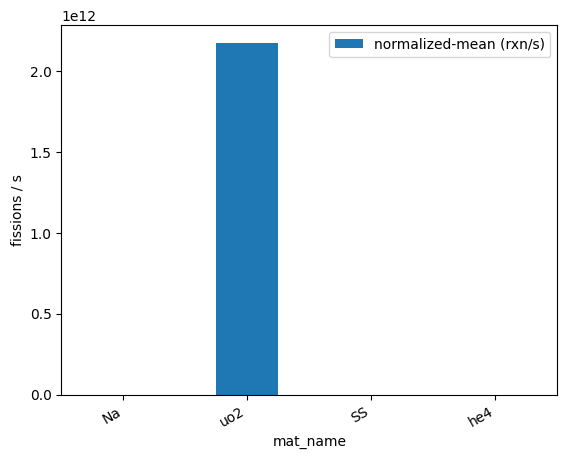

In [94]:
fission_df.plot('mat_name', 'normalized-mean (rxn/s)', kind='bar', ylabel='fissions / s')
_ = plt.xticks(rotation=30, ha='right')

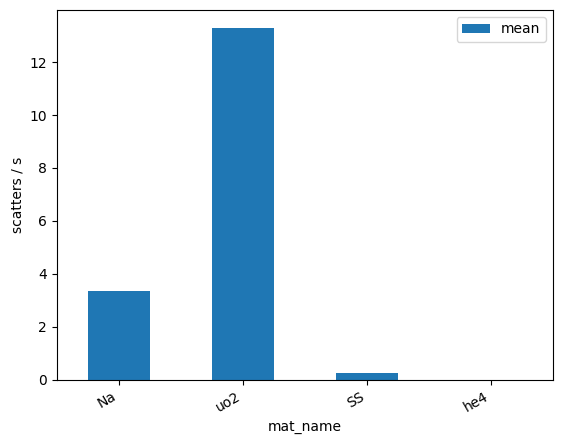

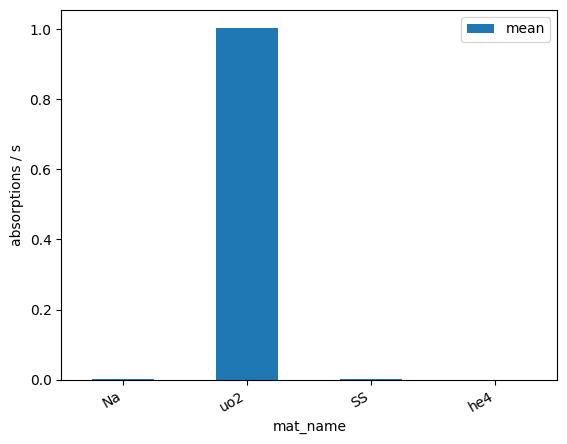

In [95]:
scatter_df = df[df['score'] == 'scatter']
scatter_df.plot('mat_name', 'mean', kind='bar', ylabel='scatters / s')
_ = plt.xticks(rotation=30, ha='right')

absorption_df = df[df['score'] == 'absorption']
absorption_df.plot('mat_name', 'mean', kind='bar', ylabel='absorptions / s')
_ = plt.xticks(rotation=30, ha='right')

---

# Universes

A universe is a collection of cells that can be used as a repeatable unit in the geometry. At a minimum, there must be one "root" universe (say, named `root`), which gets passed to `openmc.Geometry(root)`. But you can also use universes to repeat a collection of cells multiple times throughout a geometry. Here, we will explore some basic features of universes.

We'll start by making a universe which looks similar to the pincell we built earlier - say, a cylinder of UO2 enclosed by an infinite region of water. First, we set up our materials and create our geometry.

First, let's make a simplified pincell model to explore how universes work.

In [96]:
pin_surface = openmc.ZCylinder(x0=0.0, y0=0.0, r=1.0)
inside_pin = -pin_surface

pin_cell = openmc.Cell(region=inside_pin, fill=uo2)
outside_cell = openmc.Cell(region=~inside_pin, fill=sodium)

In [97]:
universe = openmc.Universe()
universe.add_cells([pin_cell, outside_cell])

We have created a universe containing a pin, enclosed in an infinite medium of water. Now let's suppose that I want to fill this universe into an enclosing cell, a cylinder of radius 5 cm. Let's first create this cylinder, and then we will fill it with our `universe`.

In [98]:
big_cylinder = openmc.ZCylinder(x0=0.0, y0=0.0,r=5.0)
big_cell = openmc.Cell()
big_cell.region = -big_cylinder
big_cell.fill = universe

Let's take a look at our geometry. In order to visualize at this stage, we need to create a universe from our `big_cell`.

/home/ubuntu/openmc/openmc/bounding_box.py:50: RuntimeWarning: invalid value encountered in add
  return (self[0] + self[1]) / 2


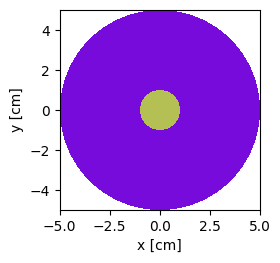

In [99]:
big_universe = openmc.Universe(cells=[big_cell])

big_universe.plot(width=(10.0, 10.0))

We can see that our `big_cell`, the large cylinder, has been filled with the `universe` we declared earlier. Let's increase the complexity a bit to understand how this filling works. What if the cylinder of UO2 in our `universe` is not located at the origin, but is instead shifted to a different position?

/home/ubuntu/openmc/openmc/bounding_box.py:50: RuntimeWarning: invalid value encountered in add
  return (self[0] + self[1]) / 2


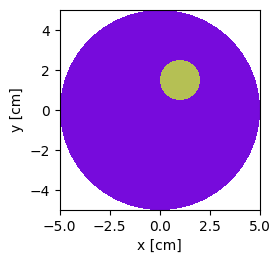

In [100]:
pin_surface.x0 = 1.0
pin_surface.y0 = 1.5

big_universe.plot(width=(10.0, 10.0))

We see that when we fill a universe inside of another cell, that there's (by default) no transformation of coordinates. You can shift the position of the universe filling a cell with the `Cell.translation` attribute. There are similar adjustments you can make, like rotations.

/home/ubuntu/openmc/openmc/bounding_box.py:50: RuntimeWarning: invalid value encountered in add
  return (self[0] + self[1]) / 2


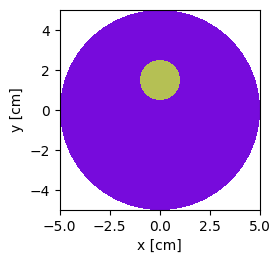

In [101]:
big_cell.translation = [-1.0, 0.0, 0.0]
big_universe.plot(width=(10.0, 10.0))

# Lattices

Lattices are a convenient way to (i) repeat a universe multiple times in space, while (ii) automatically translating that universe's origin to different positions in space.

In this exercise, we'll build two lattices, one rectangular and one hexagonal, using the CEFR pincell.

Later in this example, we will make a bunch of geometry plots.  By default, every region is colored randomly and the results are Now that we know our materials, let's define a "color specification" to use when plotting our geometry.

In [102]:
colors = {
    sodium: 'lightblue',
    steel: 'grey',
    he4: (249, 249, 249),
    uo2: (150, 0, 0)
}

### An alternative approach to building a pincell universe

Initally, we built the CEFR pincell model by specifying each surface manually. There are many convenience functions in OpenMC that make this process even easier.

In [103]:
# Define materials from inner to outer. If no material is specified (None), that region is treated as vacuum
pin_radii = [0.08020, 0.25565, 0.27112, 0.30499] # cm
pin_surfaces = [openmc.ZCylinder(r=r) for r in pin_radii]
pin_mats = [he4, uo2, he4, steel, sodium]

# Create burnable pin universe given list of surfaces and list of materials
pin_universe = openmc.model.pin(pin_surfaces, pin_mats)

# keep the innermost cell for later
fuel_cell = list(pin_universe.cells.values())[1]
print(fuel_cell)
print(fuel_cell.fill)

Cell
	ID             =	16
	Name           =	
	Fill           =	Material 1
	Region         =	(13 -14)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None

Material
	ID             =	1
	Name           =	uo2
	Temperature    =	523.15
	Density        =	0.0702131 [atom/b-cm]
	Volume         =	None [cm^3]
	S(a,b) Tables  
	Nuclides       
	U235           =	0.0149981    [ao]
	U238           =	0.00826381   [ao]
	O16            =	0.0469512    [ao]



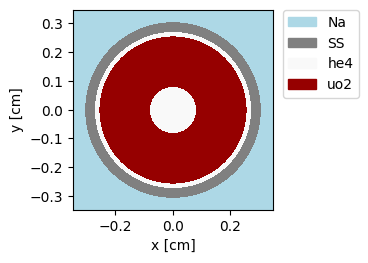

In [104]:
pin_universe.plot(width=(pitch, pitch), color_by='material', colors=colors, legend=True)

---

## Lattices in OpenMC

OpenMC has `RectLattice` and `HexLattice` objects.  For our fuel assembly, we need to use `RectLattice`. Let's look at a simple one before we do the full assembly.

First, we also need to define a universe that is all water.

In [105]:
he4_cell = openmc.Cell(fill=he4)
inf_he4 = openmc.Universe(cells=[he4_cell])
sodium_cell = openmc.Cell(fill=sodium)
inf_sodium = openmc.Universe(cells=[sodium_cell])

When creating a rectangular lattice, we need to define:

1. The lower-left coordinates of the lattice (`.lower_left`)
2. The size of each lattice element (`.pitch`)
3. The 2D arrangement of universes (`.universes`)
4. (_optionally_) A universe that is used outside of the defined region (`.outer`)

## Rectangular Lattices

In [106]:
lattice = openmc.RectLattice()

# Define the lower-left coordinates and size of lattice elements
pitch = 0.8 # cm
lattice.lower_left = (0., 0.)
lattice.pitch = (pitch, pitch)

# Now we specify what is actually inside the lattice.  This 2D lattice will be a
# list of lists like
# lattice.universes = [ [a1, a2, ...], [b1, b2, ...], ...]
# The inner lists specify columns from left to right.  The outer lists specify
# rows from top to bottom.
lattice.universes = [
    [pin_universe,   inf_he4],
    [inf_he4, pin_universe]
]


To plot the lattice, we need to put it in a universe. For this, we'll create a single cell filled with the lattice, and then put that single cell inside a universe to plot:

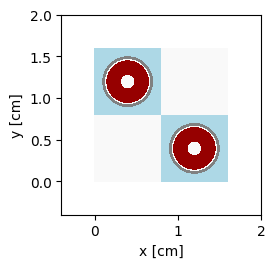

In [107]:
example_univ = openmc.Universe(cells=[openmc.Cell(fill=lattice)])

plot_args = {
    'width': (3*pitch, 3*pitch),
    'origin': (pitch, pitch, 0),
    'color_by': 'material',
    'colors': colors
}
example_univ.plot(**plot_args)

**What exactly does `outer` mean?**

In the previous section, we set the lattice outer universe to a universe containing a single cell with only water in it. To get a better sense of what the outer universe does, let's change the outer universe to the guide tube universe:

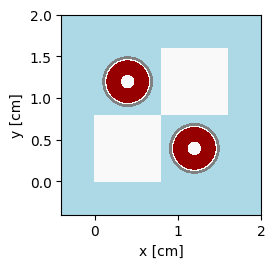

In [108]:
# We also should specify what is outside of the lattice.  In this case, it is
# the infinite water universe.
lattice.outer = inf_sodium
example_univ.plot(**plot_args)

## Hexagonal Lattices

OpenMC also allows you to define hexagonal lattices. They are a little trickier, but as we'll see there are some helper methods that demystify how to assign universes.

In [109]:
hex_lat = openmc.HexLattice()

We need to set the `center` of the lattice, the `pitch`, an `outer` universe (which is applied to all lattice elements outside of those that are defined), and a list of `universes`. Let's start with the easy ones first. Note that for a 2D lattice, we only need to specify a single number for the pitch.

In [110]:
hex_lat.center = (0., 0.)
hex_lat.pitch = [0.695]
hex_lat.outer = inf_sodium

Now we need to set the `universes` property on our lattice. It needs to be set to a list of lists of Universes, where each list of Universes corresponds to a ring of the lattice. The rings are ordered from outermost to innermost, and within each ring the indexing starts at the "top". To help visualize the proper indices, we can use the `show_indices()` helper method.

In [111]:
print(hex_lat.show_indices(num_rings=3))

            (0, 0)
      (0,11)      (0, 1)
(0,10)      (1, 0)      (0, 2)
      (1, 5)      (1, 1)
(0, 9)      (2, 0)      (0, 3)
      (1, 4)      (1, 2)
(0, 8)      (1, 3)      (0, 4)
      (0, 7)      (0, 5)
            (0, 6)


Let's setup a hexagonal lattice assembly like the one in the CEFR benchmark model.

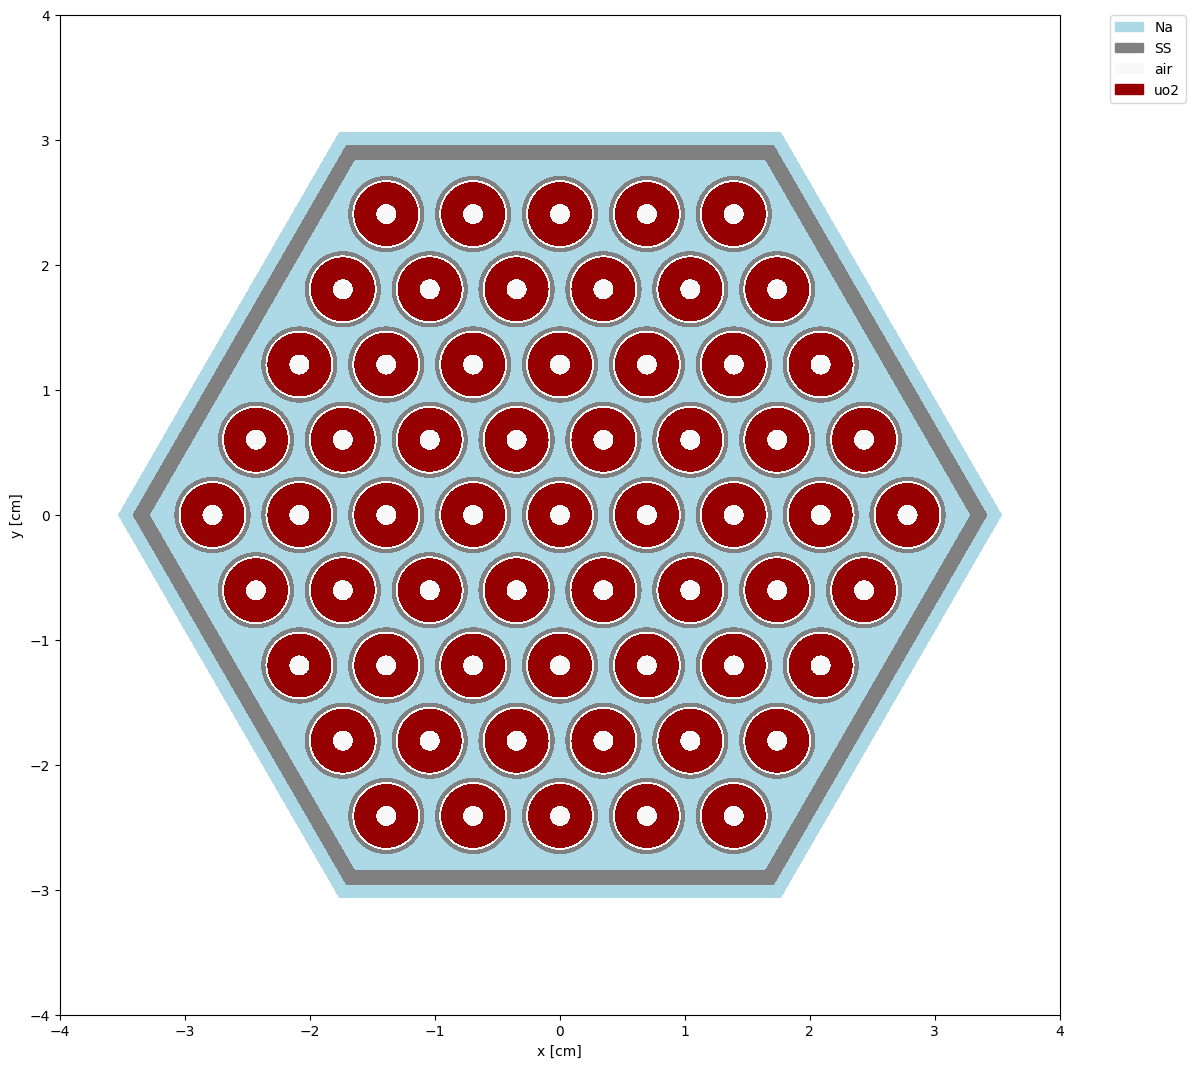

In [112]:
Image('cefr_hex_lattice.png')

In [113]:
lat_universes = []
num_rings = 5
for i in range(num_rings):
    lat_universes.append(max(6*i, 1) * [pin_universe])
hex_lat.universes = lat_universes[::-1]

Now let's put our lattice inside a circular cell.

In [114]:
outer_radius = 4.0
outer_surface = openmc.ZCylinder(r=outer_radius, boundary_type='vacuum')
main_cell = openmc.Cell(fill=hex_lat, region=-outer_surface)
root = openmc.Universe(cells=(main_cell,))

/home/ubuntu/openmc/openmc/bounding_box.py:50: RuntimeWarning: invalid value encountered in add
  return (self[0] + self[1]) / 2


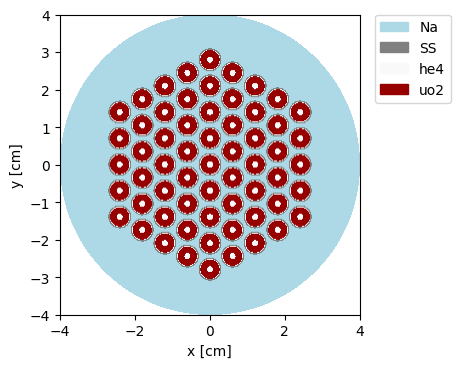

In [115]:
root.plot(width=(2*outer_radius, 2*outer_radius), pixels=(300, 300),
          color_by='material', colors=colors, legend=True)

### Rotating the lattice

Now let's say we want our hexagonal lattice orientated such that flat sides are parallel to the y-axis instead of the x-axis. This can be achieved by changing the orientation of the lattice from `'y'` to `'x'`:

In [116]:
hex_lat.orientation = 'x'

Again, we can use the `show_indices` method to see the ordering of universes within each ring:

In [117]:
print(hex_lat.show_indices(3, orientation='x'))

            (0, 8)      (0, 9)      (0,10)

      (0, 7)      (1, 4)      (1, 5)      (0,11)

(0, 6)      (1, 3)      (2, 0)      (1, 0)      (0, 0)

      (0, 5)      (1, 2)      (1, 1)      (0, 1)

            (0, 4)      (0, 3)      (0, 2)


/home/ubuntu/openmc/openmc/bounding_box.py:50: RuntimeWarning: invalid value encountered in add
  return (self[0] + self[1]) / 2


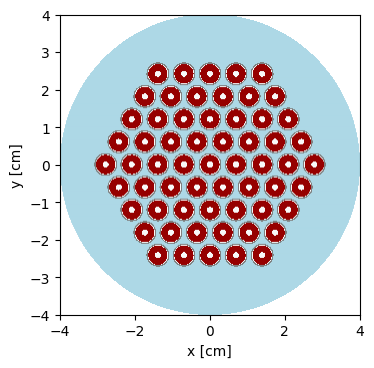

In [118]:
root.plot(width=(2*outer_radius, 2*outer_radius), pixels=(300, 300),
          color_by='material', colors=colors)

# Final CEFR Assembly Modeling Steps

The circular boundary is nice for some initial visualization, but in reality the CEFR assemblies are bounded by stainless steel ducts. Let's add those to the model now.

In the image of the CEFR assembly above, the steel duct is a hexagonal shape matching that of the hex lattice boundary. OpenMC has the ability to represent arbitrarily oriented planes to model this duct.

In [119]:
help(openmc.Plane)

Help on class Plane in module openmc.surface:

class Plane(PlaneMixin, Surface)
 |  Plane(a=1.0, b=0.0, c=0.0, d=0.0, *args, **kwargs)
 |  
 |  An arbitrary plane of the form :math:`Ax + By + Cz = D`.
 |  
 |  Parameters
 |  ----------
 |  a : float, optional
 |      The 'A' parameter for the plane. Defaults to 1.
 |  b : float, optional
 |      The 'B' parameter for the plane. Defaults to 0.
 |  c : float, optional
 |      The 'C' parameter for the plane. Defaults to 0.
 |  d : float, optional
 |      The 'D' parameter for the plane. Defaults to 0.
 |  boundary_type : {'transmission, 'vacuum', 'reflective', 'periodic', 'white'}, optional
 |      Boundary condition that defines the behavior for particles hitting the
 |      surface. Defaults to transmissive boundary condition where particles
 |      freely pass through the surface.
 |  name : str, optional
 |      Name of the plane. If not specified, the name will be the empty string.
 |  surface_id : int, optional
 |      Unique ident

However, a hexagonal shape is a common feature in reactor design and as such there is a convenience function in OpenMC for generating a hexagonal prism region.

In [120]:
help(openmc.hexagonal_prism)

Help on function hexagonal_prism in module openmc.model.funcs:

hexagonal_prism(edge_length=1.0, orientation='y', origin=(0.0, 0.0), boundary_type='transmission', corner_radius=0.0)
    Create a hexagon region from six surface planes.
    
    .. versionchanged:: 0.11
        This function was renamed from `get_hexagonal_prism` to
        `hexagonal_prism`.
    
    Parameters
    ----------
    edge_length : float
        Length of a side of the hexagon in cm
    orientation : {'x', 'y'}
        An 'x' orientation means that two sides of the hexagon are parallel to
        the x-axis and a 'y' orientation means that two sides of the hexagon are
        parallel to the y-axis.
    origin: Iterable of two floats
        Origin of the prism. Defaults to (0., 0.).
    boundary_type : {'transmission, 'vacuum', 'reflective', 'periodic'}
        Boundary condition that defines the behavior for particles hitting the
        surfaces comprising the hexagonal prism (default is 'transmission').


In [121]:
inner_duct = openmc.hexagonal_prism(orientation='x', edge_length= 3.281335614) # pitch=2.84172, Wrapper tube inner flat-to-flat/2 (cm) 
outer_duct = openmc.hexagonal_prism(orientation='x', edge_length= 3.420465482) # pitch=2.96221, Wrapper tube outer flat-to-flat/2 (cm) 
assembly_boundary = openmc.hexagonal_prism(orientation='x', edge_length= 3.536385869, boundary_type='reflective') # pitch=3.06260, S/A Pitch          flat-to-flat/2 (cm)

lattice_cell = openmc.Cell(fill=hex_lat, region=inner_duct)

assembly_universe = openmc.Universe()
assembly_universe.add_cell(lattice_cell)

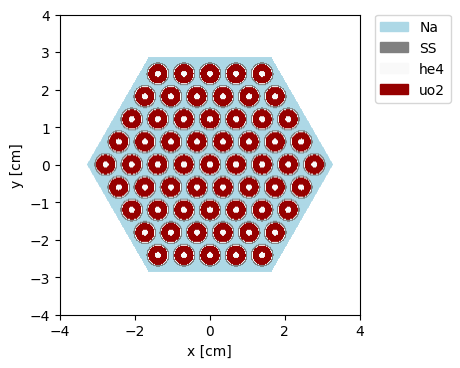

In [122]:
assembly_universe.plot(width=(2*outer_radius, 2*outer_radius), pixels=(300, 300),
                       color_by='material', colors=colors, legend=True)

Now we can create the external duct and outer cells

In [123]:
duct_cell = openmc.Cell(fill=steel, region=~inner_duct & outer_duct)
assembly_universe.add_cell(duct_cell)

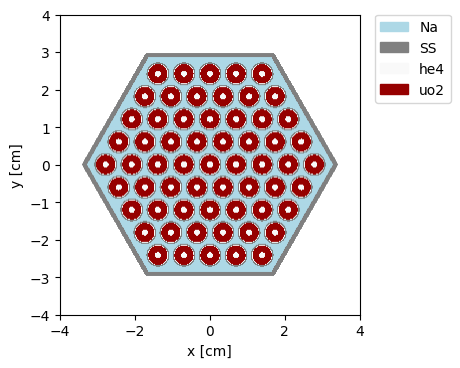

In [124]:
assembly_universe.plot(width=(2*outer_radius, 2*outer_radius), pixels=(300, 300),
                       color_by='material', colors=colors, legend=True)

Finally, we need an outer cell representing the space between assembly ducts.

In [125]:
outer_cell = openmc.Cell(region=~outer_duct & assembly_boundary, fill=sodium)
assembly_universe.add_cell(outer_cell)

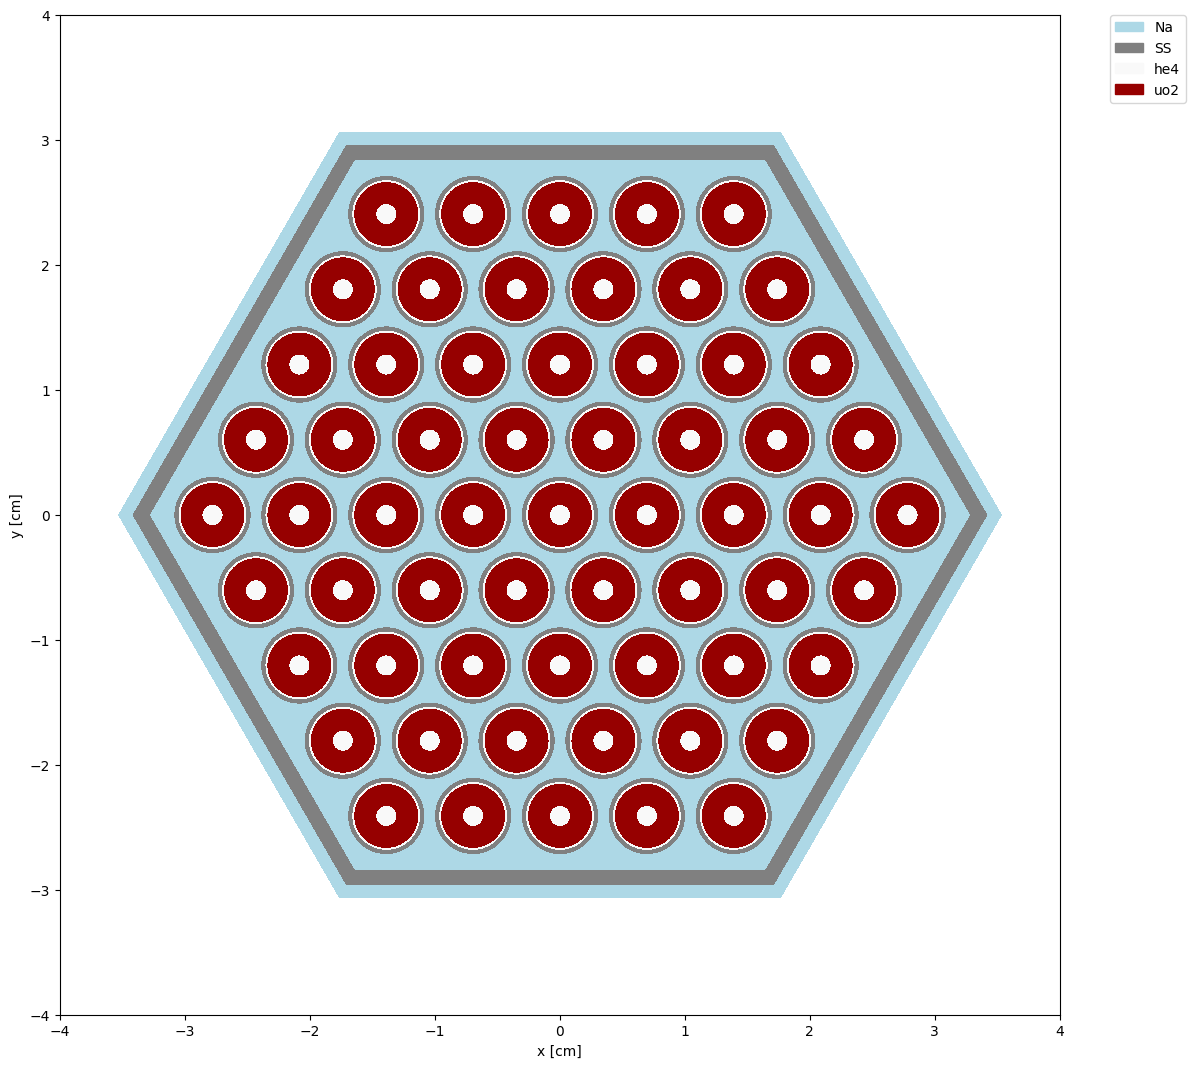

In [126]:
assembly_universe.plot(width=(2*outer_radius, 2*outer_radius), pixels=(1000, 1000),
                       color_by='material', colors=colors, legend=True)

Finally, let's make this a 3D model by adding upper and lower bounding planes.

In [127]:
print(assembly_universe.cells)

OrderedDict([(24, Cell
	ID             =	24
	Name           =	
	Fill           =	11
	Region         =	(-18 19 -20 21 22 -23)
	Rotation       =	None
	Translation    =	None
	Volume         =	None
), (25, Cell
	ID             =	25
	Name           =	
	Fill           =	Material 3
	Region         =	(~(-18 19 -20 21 22 -23) (-24 25 -26 27 28 -29))
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
), (26, Cell
	ID             =	26
	Name           =	
	Fill           =	Material 5
	Region         =	(~(-24 25 -26 27 28 -29) (-30 31 -32 33 34 -35))
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
)])


In [128]:
openmc.ZPlane?

Init signature: openmc.ZPlane(z0=0.0, *args, **kwargs)
Docstring:     
A plane perpendicular to the z axis of the form :math:`z - z_0 = 0`

Parameters
----------
z0 : float, optional
    Location of the plane in [cm]. Defaults to 0.
boundary_type : {'transmission, 'vacuum', 'reflective', 'periodic', 'white'}, optional
    Boundary condition that defines the behavior for particles hitting the
    surface. Defaults to transmissive boundary condition where particles
    freely pass through the surface. Only axis-aligned periodicity is
    supported, i.e., x-planes can only be paired with x-planes.
name : str, optional
    Name of the plane. If not specified, the name will be the empty string.
surface_id : int, optional
    Unique identifier for the surface. If not specified, an identifier will
    automatically be assigned.

Attributes
----------
z0 : float
    Location of the plane in [cm]
boundary_type : {'transmission, 'vacuum', 'reflective', 'periodic', 'white'}
    Boundary condition

In [129]:
lower_plane = openmc.ZPlane(-20.0, boundary_type='vacuum')
upper_plane = openmc.ZPlane(20.0, boundary_type='vacuum')
root_cell = openmc.Cell(region=assembly_boundary & +lower_plane & -upper_plane, fill=assembly_universe)
root_universe = openmc.Universe(cells=[root_cell])
# for id, cell in assembly_universe.cells.items():
#     cell.region &= +lower_plane & -upper_plane

We should now be able to use this as our geometry in the model and run it successfully.

In [130]:
model.geometry = openmc.Geometry(root=root_universe)
model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

PosixPath('/home/ubuntu/ictp-workshop23-openmc/notebooks/openmc_tutorial/statepoint.50.h5')

---

# Advanced Tallies in OpenMC: Pincell Power Distributions



For this part of the exercise we're going to setup tallies that will provide us the pincell powers in the assembly we've created.

In [131]:
# define ANL 33 group structure
ANL_33 = \
[1.000000E-05, 
4.174600E-01,
5.315800E-01,
3.927900E+00,
8.315300E+00,
1.371000E+01,
2.260300E+01,
3.726700E+01,
6.144200E+01,
1.013000E+02,
1.670200E+02,
2.753600E+02,
4.540000E+02,
7.485200E+02,
1.234100E+03,
2.034700E+03,
3.354600E+03,
5.530800E+03,
9.118800E+03,
1.503400E+04,
2.478700E+04,
4.086800E+04,
6.737900E+04,
1.110900E+05,
1.831600E+05,
3.019700E+05,
4.978700E+05,
8.208500E+05,
1.353400E+06,
2.231300E+06,
3.678800E+06,
6.065300E+06,
1.000000E+07,
1.419100E+07]

In [132]:
###############################################################################
#                   Exporting to OpenMC tallies.xml File
###############################################################################

# Instantiate a distribcell Tally
tally_pin_power = openmc.Tally(name='pin powers')
tally_pin_power.filters = [openmc.DistribcellFilter(fuel_cell)]
tally_pin_power.scores = ['kappa-fission', 'flux']

tally_flux_spectrum = openmc.Tally(name='flux tally')
energy_filter = openmc.EnergyFilter(ANL_33) # ANL 33-group structure
tally_flux_spectrum.filters = [energy_filter]
tally_flux_spectrum.scores = ['flux']

tally_global = openmc.Tally(name='global tally')
tally_global.scores = ['kappa-fission']

# Instantiate a Tallies collection and export to XML
model.tallies = openmc.Tallies([tally_pin_power, tally_flux_spectrum, tally_global])

In [133]:
statepoint = model.run(output=False)

In [134]:
import openmc.lib
def display_pin_powers(statepoint_file, pincell_tally, global_tally, origin):

    assembly_power = 65 / 79 * 1e6 # [W] (zero power test)

    with openmc.StatePoint(statepoint_file, autolink=False) as sp:
        pincell_tally = sp.get_tally(name=pincell_tally.name)
        tally_global_out = sp.get_tally(name=global_tally.name)
    
    total_kappa_fission = tally_global_out.get_values(scores=['kappa-fission']).flatten()[0]

    pincell_powers = pincell_tally.get_values(scores=['kappa-fission']).flatten()
    pincell_powers *= assembly_power / total_kappa_fission
    dcell_filter = pincell_tally.find_filter(openmc.DistribcellFilter)
    dcell = dcell_filter.bins[0]
    
    try:
        print('Initializing OpenMC...')
        openmc.lib.init(['-c'])
        print('Done')
        p = openmc.lib.plot._PlotBase()
        p.origin = origin
        p.width = 7
        p.height = 7
        p.h_res = 400
        p.v_res = 400
        p.colorby = 'cell'
        p.basis = 'xy'
        print('Generating id map...')
        id_mapping = openmc.lib.id_map(p)
        print('Done')
    finally:
        print('Shutting down OpenMC...')
        openmc.lib.finalize()
        print('Done')

    cell_map = id_mapping[:, :, 0]
    instance_map = id_mapping[:, :, 1]
    fuel_mask = cell_map == dcell
    power_mapping = np.zeros_like(cell_map, dtype=float)
    
    for i, h in enumerate(pincell_powers.flatten()):
        instance_mask = instance_map == i
        power_mapping[np.logical_and(fuel_mask, instance_mask)] = h

    power_mapping[power_mapping == 0.0] = np.nan
    
    plt.figure(figsize=(10,10))
    img = plt.imshow(power_mapping, extent=[-3.5, 3.5, -3.5, 3.5])
    plt.ylabel('Y')
    plt.xlabel('X')
    plt.colorbar(img, label='Power (W)')
    plt.show()

Initializing OpenMC...
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
               

          favor of the ./model.xml file.


 Reading Fe54 from /home/ubuntu/data/endfb71_hdf5/Fe54.h5
 Reading Fe56 from /home/ubuntu/data/endfb71_hdf5/Fe56.h5
 Reading Fe57 from /home/ubuntu/data/endfb71_hdf5/Fe57.h5
 Reading Fe58 from /home/ubuntu/data/endfb71_hdf5/Fe58.h5
 Reading C0 from /home/ubuntu/data/endfb71_hdf5/C0.h5
 Reading He3 from /home/ubuntu/data/endfb71_hdf5/He3.h5
 Reading He4 from /home/ubuntu/data/endfb71_hdf5/He4.h5
 Reading Na23 from /home/ubuntu/data/endfb71_hdf5/Na23.h5
 Minimum neutron data temperature: 600 K
 Maximum neutron data temperature: 600 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
Done
Generating id map...
Done
Shutting down OpenMC...
Done


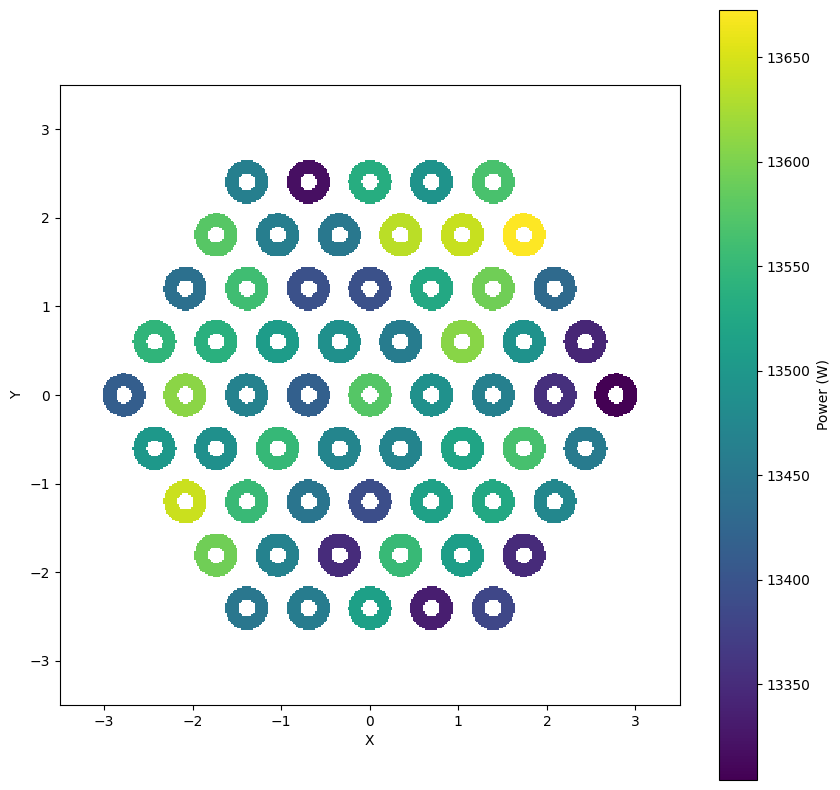

In [135]:
display_pin_powers(statepoint, tally_pin_power, tally_global, (0.0, 0.0, 0.0))

In [136]:
import random
random.choice(list(root_cell.region.get_surfaces().values())).boundary_type = 'vacuum'